## Convolutional Neural Network (CNN) model trained on PDE One Dimensional Nonequilbrium Energy Balance Model with Diffusion



### before executing this notebook: Install torch
pip install torch

or

sudo pip install torch

or

install a suite that has pytorch





# PDE model (from HW5)

In [1]:
# One Dimensional Nonequilbrium Energy Balance Model with Diffusion 
import numpy as np
import matplotlib.pyplot as plt
from   scipy.integrate import solve_ivp
import time

%matplotlib inline

# Physical constants 
Re     = 6.371E6        # Radius of Earth in m
eps    = 0.82           # Emissivity fraction
sigma  = 5.67E-8        # Stephan Boltzmann constant in W / m^2 / K^4
c_s    = 712            # heat capacity of Silicon rock in J /kg / K
rho_s  = 2650           # density of Silicon rock in kg/m^3
c_w    = 4000           # heat capacity of water in J /kg / K
rho_w  = 1000           # density of water in kg/m^3
years  = 365.25*24*3600 # seconds in a year
S0     = 1361           # solar insolation in W m-2
dg2rad = np.pi/180.0    # converstion factor for degree to radians
days   = 24*3600        # seconds per day

# set model parameters
alpha = 0.32             # Albedo of earth
eps   = 0.82             # Emissivity 
depth = 100              # Depth of ocean mixed layer/land active layer, in m

# create grid and set initial conditions
N     = 64 #50 #300                         # set number of segments
y_F   = np.linspace(-1,1,N+1)       # set position of interfaces
y_T   = (y_F[0:N]+y_F[1:N+1])/2     # set position of midpoints
dy    = y_F[1]-y_F[0]               # get segment length
model_lat   = np.arcsin(y_T)/dg2rad       # latitude at segment centers

# Set the diffusion coefficient
D1     = 0.1              # diffusion coefficient

# set time integration parameters
t_end = 25*years                   # integration end time
dt    = 10*days                    # time integration maxium step size
out_dt= 60*days                    # time between plots
times = np.arange(0,t_end,out_dt)  # array of timesteps for output

# set initial conditions 
T0 = 288 + 0*y_T                     # constant initial temperature                   


# Calculate Heat capacity 
### Heat capacity of earth, 70% ocean and 30% silicate land of 100 m depth
vol= 4 *np.pi* Re**2 * depth                                 # Volume of top x-meters of earth (given by depth)
C_e = 0.7 * (c_w * vol * rho_w) + 0.3 * (c_s * vol * rho_s ) # heat capacity of earth in J K-1
Cbar  =  C_e/(4*np.pi*Re**2)                                 # heat capacity per unit area in J m-2 K-1 

In [2]:
def RHS(t,T):
    # compute energy flux F at interfaces
    F     = np.zeros(N+1)
    
    #F = -D*(1-y^2)         *(T[i]-T[i-1]/dy)
    F[1:N] = -D1*(1-y_F[1:N]**2)*(T[1:N]-T[0:N-1])/dy
    #F[1:N] = -D1*(T[1:N]-T[0:N-1])/dy
    
    F[0]  = 0               # apply no flux b.c. at y=-1
    F[N]  = 0               # apply no flux b.c. at y=+1
    
    # compute diffusion term at the segment centers
    #diffusion = -(F[1:N+1]-F[0:N])/dy
    diffusion =  (F[1:N+1]-F[0:N])/dy
    
    # Incoming short wave
    ASR = S0/4 * (1-alpha) * (1.241-0.723*y_T**2)
    
    #Outgoing long wave
    OLR = (1-eps/2) * sigma * T**4
    # compute right-hand-side of the equation
    #rhs = (ASR - OLR + diffusion)/Cbar 
    
    s = 1.241 - (0.723*(y_T**2))
    rhs = ((S0/4)*s*(1-alpha)-(1-eps/2)*sigma*T**4-diffusion)/(Cbar)
    
    return rhs


# CNN Model

In [3]:
import torch
import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable


In [4]:
nvars = 1  # number of variables - in the case of T, it's just one, if we added flux you would have 2 
res = 64   # number of y grid points

# define model 
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        # convolution #1 (make an abstract of input)
        self.conv11 = nn.Sequential(
            #nn.BatchNorm1d(nvars),
            nn.Conv1d(
                in_channels=nvars, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # convolution #2
        self.conv22 = nn.Sequential(
            nn.Conv1d(
                in_channels=128, out_channels=256, kernel_size=4, 
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # convolution #3
        self.conv33 = nn.Sequential(
            nn.Conv1d(
                in_channels=256, out_channels=512, kernel_size=4, 
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # deconvolution #1 (reconstitute previous abstract, undoes previous convolution)
        self.conv0 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=512, out_channels=256, kernel_size=4, 
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # deconvolution #2
        self.conv1 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=256, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # deconvolution #3 - final decovolution produces final output (the next iteration approximation)
        self.conv2 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=128+128, out_channels=nvars, kernel_size=4, 
                stride=2, padding=1, bias=True
            ),
            #nn.BatchNorm1d(nvars),
            nn.LeakyReLU(0.2, inplace=True)
        )

    # run input through network - this is know as the "forward function"
    def forward(self, x1):

        # Convolutional layers
        x2 = self.conv11(x1)        
        x = self.conv22(x2) 
        x = self.conv33(x) 
        
        # deconvolution layers
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(torch.cat((x, x2), dim=1))    # this is alsos a "cross link to the input" helps with vanishing gradient probem
                
        return x

In [5]:
# randomly initialize weights
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

# Create Network instances and init weights
generator = GenerativeNet()
generator.double()
generator.apply(init_weights)

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()

In [7]:
# Optimizers - helps figure out optimal step size for training
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function - we're using mse
loss = nn.BCELoss()
mse = nn.MSELoss()

In [8]:
def train_generator(optimizer, tin, target):
    # Reset gradients
    optimizer.zero_grad()
    
    # minimize loss between predicted vs actual values from rk4
    generated = generator(tin) 
    mse_loss = mse(generated, target.detach())
    mse_loss.backward()
    
    # Update weights with gradients
    optimizer.step()
        
    # Return error
    return mse_loss 

In [9]:
# number of initial T profiles to train on
num_epochs = 100    #1000

for epoch in range(0, num_epochs):
    
    #################################
    ### run RK4 to get target values
    #################################
    
    # set initial conditions 
    #T0 = 288 + 0*y_T                     # constant initial temperature 
    #T0 = np.random.rand(len(y_T))*288
    T0 = np.random.rand(len(y_T))*50+250

    # set time integration parameters and call time integrator to solve the equation numerically 
    t_end = 25*years                   # integration end time
    dt    = 1*days                    # time integration maxium step size
    out_dt= 60*days                    # time between plots
    times = np.arange(0,t_end,out_dt)  # array of timesteps for output
    solution = solve_ivp(RHS, (0,t_end), T0, "RK45", times, max_step=dt )

    # extract time and temperature fields from the solution
    t = solution.t
    T = solution.y
    
    
    #############################################################
    ## train CNN with intermediate profiles from above RK4 step
    #############################################################
    
    for jj in range(0, len(T[0])-16-1, 16):
        isample = T[:,jj] /330.
        osample = T[:,jj+16]/330.

        # cast to tensor
        isample = torch.tensor(np.reshape(isample, (1, nvars, res))) #.float()
        osample = torch.tensor(np.reshape(osample, (1, nvars, res))) #.float()

        err = train_generator(g_optimizer, isample, osample)
    
    # report training error
    if epoch%10 == 0:
        print("epoch, mse err:", epoch, float(err))



epoch, mse err: 0 0.753702389733512
epoch, mse err: 10 0.18888874525974708
epoch, mse err: 20 0.005163167178110725
epoch, mse err: 30 8.044200408250591e-05
epoch, mse err: 40 5.481444805419893e-06
epoch, mse err: 50 1.7848333341478774e-06
epoch, mse err: 60 2.5751359029566887e-06
epoch, mse err: 70 1.6619296853794184e-06
epoch, mse err: 80 1.6247386463605545e-06
epoch, mse err: 90 1.2723247280563184e-06


In [9]:
# test a single iteration
generator(torch.tensor(np.reshape(T0/330, (1, nvars, res))))

tensor([[[0.7989, 0.8089, 0.8175, 0.8266, 0.8343, 0.8371, 0.8396, 0.8389,
          0.8415, 0.8482, 0.8510, 0.8558, 0.8576, 0.8576, 0.8587, 0.8589,
          0.8590, 0.8611, 0.8630, 0.8646, 0.8648, 0.8662, 0.8658, 0.8635,
          0.8618, 0.8699, 0.8698, 0.8699, 0.8697, 0.8721, 0.8723, 0.8696,
          0.8712, 0.8746, 0.8765, 0.8782, 0.8789, 0.8810, 0.8812, 0.8808,
          0.8817, 0.8779, 0.8767, 0.8738, 0.8724, 0.8724, 0.8707, 0.8679,
          0.8660, 0.8577, 0.8553, 0.8512, 0.8484, 0.8459, 0.8434, 0.8405,
          0.8367, 0.8355, 0.8313, 0.8276, 0.8250, 0.8194, 0.8151, 0.8093]]],
       dtype=torch.float64, grad_fn=<AsStridedBackward>)

# Run numerical model and save results for comparison as T

run time: 2.363842725753784


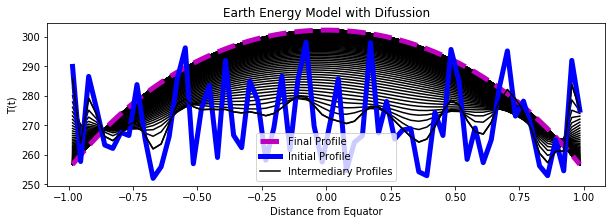

In [19]:
# set time integration parameters
t_end = 25*years                   # integration end time
dt    = 1*days                    # time integration maxium step size
out_dt= 60*days                    # time between plots
times = np.arange(0,t_end,out_dt)  # array of timesteps for output

# set initial conditions 
#T0 = 288 + 0*y_T                     # constant initial temperature 
#T0 = np.random.rand(len(y_T))*50+250
T0 = np.random.rand(len(y_T))*50+250



# call time integrator to solve the equation numerically 
start_time = time.time()
solution = solve_ivp(RHS, (0,t_end), T0, "RK45", times, max_step=dt )
print("run time:", time.time() - start_time)  


# extract time and temperature fields from the solution
t = solution.t
T = solution.y

fig = plt.figure(figsize=(10,3))
plt.plot(y_T, T,'k');
plt.plot(y_T, T[:,-1],'m--',linewidth=5.0,label="Final Profile");  #re-plot first, last, and 2nd profiles for legend
plt.plot(y_T, T[:,0],'b',linewidth=5.0,label="Initial Profile");
plt.plot(y_T, T[:,1],'k',label="Intermediary Profiles");
plt.xlabel('Distance from Equator')
plt.ylabel('T(t)')
plt.legend(loc="lower center")
plt.title('Earth Energy Model with Difussion');


run time: 0.11552596092224121


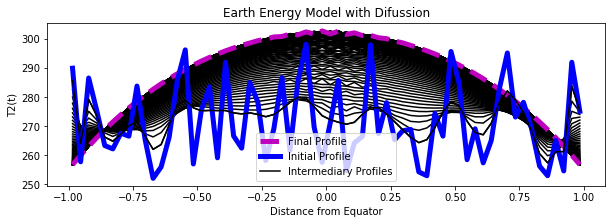

In [20]:
# Case2: dt = dt *6*16
# set time integration parameters
t_end = 25*years                   # integration end time
dt    = 6*10*days                    # time integration maxium step size
out_dt= 60*days                    # time between plots
times = np.arange(0,t_end,out_dt)  # array of timesteps for output

# Note: using same T0 from previous RK4 run

# call time integrator to solve the equation numerically 
start_time = time.time()
solution = solve_ivp(RHS, (0,t_end), T0, "RK45", times, max_step=dt )
print("run time:", time.time() - start_time)  


# extract time and temperature fields from the solution
t = solution.t
T2 = solution.y

fig = plt.figure(figsize=(10,3))
plt.plot(y_T, T2,'k');
plt.plot(y_T, T2[:,-1],'m--',linewidth=5.0,label="Final Profile");  #re-plot first, last, and 2nd profiles for legend
plt.plot(y_T, T2[:,0],'b',linewidth=5.0,label="Initial Profile");
plt.plot(y_T, T2[:,1],'k',label="Intermediary Profiles");
plt.xlabel('Distance from Equator')
plt.ylabel('T2(t)')
plt.legend(loc="lower center")
plt.title('Earth Energy Model with Difussion');


# Now run the CNN model and plot against numerical model for comparison

run time: 0.07659125328063965


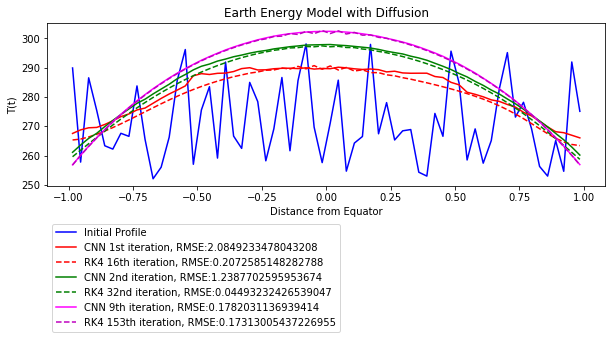

In [21]:
# Run CNN on same T0 as above

#cnn_y_T0 = T0
cnn_y_T1 = generator(torch.tensor(np.reshape(T0/330, (1, nvars, res))))
cnn_y_T2 = generator(cnn_y_T1)

# run 9 iterations of CNN model
cnn_y_T3 = torch.tensor(np.reshape(T0/330, (1, nvars, res)))
start_time = time.time()
for ii in range(9):
    cnn_y_T3 = generator(cnn_y_T3)
print("run time:", time.time() - start_time)  
    
# plot initial profile
fig = plt.figure(figsize=(10,3))
plt.plot(y_T, T[:,0],'b',label="Initial Profile");

# plot 1st CNN iteration
cnnT = cnn_y_T1[0,0].detach().numpy()*330
err = ((cnnT - T[:,16])**2).mean()
plt.plot(y_T, cnnT,'red', label="CNN 1st iteration, RMSE:"+str(np.sqrt(err)))
err = ((T2[:,16] - T[:,16])**2).mean()
plt.plot(y_T, T2[:,16],'r--', label="RK4 16th iteration, RMSE:"+str(np.sqrt(err)))

# plot 2nd CNN iteration
cnnT = cnn_y_T2[0,0].detach().numpy()*330
err = ((cnnT - T[:,32])**2).mean()
plt.plot(y_T, cnnT,'green', label="CNN 2nd iteration, RMSE:"+str(np.sqrt(err)))
err = ((T2[:,32] - T[:,32])**2).mean()
plt.plot(y_T, T2[:,32],'g--', label="RK4 32nd iteration, RMSE:"+str(np.sqrt(err)))
#plt.plot(y_T, T2[:,32],'k--');

# plot final iteration and
cnnT = cnn_y_T3[0,0].detach().numpy()*330
err = ((cnnT - T[:,152])**2).mean()
plt.plot(y_T, cnnT, 'magenta', label="CNN 9th iteration, RMSE:"+str(np.sqrt(err)))
err = ((T2[:,152] - T[:,152])**2).mean()
plt.plot(y_T, T2[:,152],'m--', label="RK4 153th iteration, RMSE:"+str(np.sqrt(err)))

# plt.plot(y_T, T[:,7:8],'m--',linewidth=5.0,label="Final Profile");  #re-plot first, last, and 2nd profiles for legend
# plt.plot(y_T, T[:,0],'b',linewidth=5.0,label="Initial Profile");
# plt.plot(y_T, T[:,1],'k',label="Intermediary Profiles");
plt.xlabel('Distance from Equator')
plt.ylabel('T(t)')
plt.legend(loc="lower center")
plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(0, -.2), loc='upper left')
#ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Earth Energy Model with Diffusion');

In [35]:
T.shape

(64, 153)